In [4]:
from __future__ import (
    print_function,
    division
)

import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
import numpy as np
import feather
import pickle
import random
import glob
import time
import sys
sys.path.append('../src')
import os


from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score
)

from typing import (
    Callable,
    Iterable,
    List
)

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)

from tqdm.notebook import tqdm_notebook

from tqdm import tqdm

from sklearn.utils.validation import (
    check_X_y, 
    check_array
)

tqdm_notebook.pandas()

# Utility Functions

In [3]:
def confusion_matrix(
    labels:Iterable[list or np.ndarray],
    preds:Iterable[list or np.ndarray]
    ) -> pd.DataFrame:
    """ Takes desireds/labels and softmax predictions, return a confusion matrix. """
    label = pd.Series(
        labels,
        name='Actual'
    )
    pred = pd.Series(
        preds,
        name='Predicted'
    )
    return pd.crosstab(
        label,
        pred
    )


def visualize_confusion_matrix(
    data:np.ndarray,
    normalize:bool = True,
    title:str = " "
) -> None:
    
    if normalize:
        data /= np.sum(data)

    plt.figure(figsize=(15,15))
    sns.heatmap(data, 
                fmt='.2%',
                cmap = 'Greens')

    plt.title(title)
    plt.show()


def save_obj(obj:object, path:str = None) -> None:
    with open(path + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

        
def load_obj(path:str = None) -> object:
    with open(path + '.pkl', 'rb') as f:
        return pickle.load(f)


def save(data:np.ndarray = None,path:str = None) -> None:
    np.save(path + '.npy', data, allow_pickle=True)


def load(path:str = None) -> np.ndarray:
    return np.load(path + '.npy', allow_pickle=True) 

# Data Reading & Injection

In [5]:
current_dir = os.getcwd()
data_dir = os.path.join('../data', 'fma_metadata')
result_dir = os.path.join(current_dir, 'results')

tracks = pd.read_csv(
    os.path.join(data_dir, 'tracks.csv'),
    index_col=0, 
    header = [0, 1]
)

features = pd.read_csv(
    os.path.join(data_dir, "features.csv"),
    index_col=0,
    header = [0, 1, 2]
)

# Data Splitting

In [6]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((84353, 140), (84353,), (11263, 140), (11263,))

In [8]:
feature_cols = X_train.columns

In [7]:
undrop_cond_train = y_train.isna() != True
y_train = y_train[undrop_cond_train]
X_train = X_train[undrop_cond_train]

undrop_cond_test = y_test.isna() != True
y_test = y_test[undrop_cond_test]
X_test = X_test[undrop_cond_test]

# Dimension Reduction & Visualization

In [8]:
import plotly.io as plt_io
import plotly.graph_objects as go


def plot_2d(component1:np.ndarray, component2:np.ndarray,  path:str, y = None,) -> None:
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y, #set color equal to a variable
            colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict(l=100,r=100,b=100,t=100),width=2000,height=1200)                 
    fig.layout.template = 'plotly_dark'
    
    fig.show()
    
    
    fig.write_image(path)

def plot_3d(component1: np.ndarray,
            component2 : np.ndarray,
            component3 :np.ndarray,
            path:str,
            y = None) -> None:
    
    fig = go.Figure(data=[go.Scatter3d(
            x=component1,
            y=component2,
            z=component3,
            mode='markers',
            marker=dict(
                size=10,
                color=y,                # set color to an array/list of desired values
                colorscale='Rainbow',   # choose a colorscale
                opacity=1,
                line_width=1
            )
        )])
    # tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
    fig.layout.template = 'plotly_dark'

    fig.show()
    fig.write_image(path)
    

In [9]:
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y_train)

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## PCA

In [ ]:
x = X_train.copy()
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

principal = pd.DataFrame(
    data = principalComponents,
    columns = [
        'PC 1',
        'PC 2',
        'PC 3'
    ]
)

plot_2d(
    principalComponents[:, 0],
    principalComponents[:, 1],
    y = y,
    path = os.path.join(current_dir, result_dir, 'pca_2d.png')
)

In [ ]:
plot_3d(
    principalComponents[:, 0],
    principalComponents[:, 1],
    principalComponents[:, 2],
    path = os.path.join(current_dir, result_dir, 'pca_3d.png'),
    y = y
)

## Linear Discriminant Analysis

In [ ]:
x = X_train.copy()
lda = LDA(n_components=3)
embedding = lda.fit_transform(x, y)

plot_3d(
    embedding[:, 0],
    embedding[:, 1],
    embedding[:, 2],
    path = os.path.join(current_dir, result_dir, 'lda_3d.png'),
    y = y
)

## Manifold Learning : T-distributed Stochastic Neighbor Embedding

In [ ]:
x = X_train.copy()
pca = PCA(n_components=100)
principalComponents = pca.fit_transform(x)

tsne = TSNE(n_components=3)
embedding = tsne.fit_transform(principalComponents)

plot_3d(
    embedding[:, 0],
    embedding[:, 1],
    embedding[:, 2],
    path = os.path.join(current_dir, result_dir, 'TSNE_3d.png'),
    y = y
)

# Modelling 

In [12]:
unique_genres = np.unique(y_train)
unique_genres

array(['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic',
       'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International',
       'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken'],
      dtype=object)

In [9]:
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

from sklearn.linear_model import (
    LogisticRegression, 
    Perceptron,
    SGDClassifier,
    RidgeClassifier,
)

from sklearn.svm import (
    SVC, 
    LinearSVC,
    NuSVC
)


from sklearn.neighbors import (
    KNeighborsClassifier,
    NearestCentroid
)

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [10]:
models = {
    RandomForestClassifier.__name__ : RandomForestClassifier(),
    BaggingClassifier.__name__: BaggingClassifier(),
    ExtraTreesClassifier.__name__ :ExtraTreesClassifier(),
    AdaBoostClassifier.__name__: AdaBoostClassifier(),
    #GradientBoostingClassifier.__name__: GradientBoostingClassifier(),
    LogisticRegression.__name__: LogisticRegression(),
    Perceptron.__name__: Perceptron(),
    SGDClassifier.__name__: SGDClassifier(),
    RidgeClassifier.__name__: RidgeClassifier(),
    SVC.__name__: SVC(),
    LinearSVC.__name__: LinearSVC(),
    #NuSVC.__name__: NuSVC(),
    KNeighborsClassifier.__name__: KNeighborsClassifier(),
    NearestCentroid.__name__: NearestCentroid(),
    MLPClassifier.__name__: MLPClassifier(),
    DecisionTreeClassifier.__name__: DecisionTreeClassifier(),
    GaussianNB.__name__: GaussianNB(),
}

metrics = {
    accuracy_score.__name__ : accuracy_score, 
    recall_score.__name__ : recall_score, 
    precision_score.__name__: precision_score,
    f1_score.__name__ : f1_score, 
    #roc_auc_score.__name__ : roc_auc_score
}

## Data Scaling

In [31]:
scaler = StandardScaler() #or MinMax
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Model Selection Loop

In [142]:
scores = {}

for model_name, model in models.items():
    print(f"{model_name} is fitting." )

    model_cache = {}
    since = time.time()

    model.fit(
        X_train,
        y_train
    )

    model_cache['fitted_time(s)'] = time.time() - since

    preds = model.predict(X_test)

    
    for metric_name, metric in metrics.items():

        if any(
            [
                metric_name == 'precision_score',
                metric_name == 'recall_score',
                metric_name == 'f1_score'
            ]
        ):
            model_cache[metric_name] = metric(
                y_test,
                preds,
                average='micro'
            )

        else:
            model_cache[metric_name] = metric(
                y_test,
                preds
            )


    scores[model_name] = model_cache

RandomForestClassifier is fitting.
BaggingClassifier is fitting.
ExtraTreesClassifier is fitting.
AdaBoostClassifier is fitting.
LogisticRegression is fitting.


/Users/cankocagil/miniforge3/envs/rl_bot/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Perceptron is fitting.
SGDClassifier is fitting.
RidgeClassifier is fitting.
SVC is fitting.
LinearSVC is fitting.


/Users/cankocagil/miniforge3/envs/rl_bot/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



KNeighborsClassifier is fitting.
NearestCentroid is fitting.
MLPClassifier is fitting.


/Users/cankocagil/miniforge3/envs/rl_bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



DecisionTreeClassifier is fitting.
GaussianNB is fitting.


In [ ]:
df_scores = pd.DataFrame(scores).T

df_scores = df_scores[
    [
       'accuracy_score',
       'precision_score',
       'recall_score',
       'f1_score',
       'fitted_time(s)'
    ]
].sort_values('accuracy_score', ascending = False)

In [150]:
df_scores.to_csv(
    os.path.join(result_dir, 'ml-baseline-scores.csv')
)

# Cross-Validation

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [39]:
scores = cross_val_score(
    MLPClassifier(
        hidden_layer_sizes= (64, ),
        max_iter=200,
        warm_start=True,
    ),
    X_train,
    y_train, 
    cv=5,
    #return_estimator=True
)

/Users/cankocagil/miniforge3/envs/rl_bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/cankocagil/miniforge3/envs/rl_bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cankocagil/miniforge3/envs/rl_bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cankocagil/miniforge3/envs/rl_bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cank

In [40]:
print(" Multi-layer Percoptron Classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

 Multi-layer Percoptron Classifier has 0.56 accuracy with a standard deviation of 0.02


In [38]:
scores = cross_val_score(
    SVC(
        kernel = 'rbf'
    ),
    X_train, 
    y_train,
    cv=5
)

print(" Support Vector Classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

 Support Vector Classifier has 0.60 accuracy with a standard deviation of 0.02


# Ensemble Learning

In [27]:
ensemble_models = [
    #GradientBoostingClassifier(),
    VotingClassifier(
        estimators = [
            ('MLP', MLPClassifier()),
            ('SVC', SVC(kernel = 'rbf'))
        ]
    ),
    VotingClassifier(
        estimators = [
            ('KNN', KNeighborsClassifier()),
            ('RFC', RandomForestClassifier(n_estimators=50, random_state=1)),
            ('GaussianNB', GaussianNB())
        ]
    ),
    VotingClassifier(
        estimators = [
            ('MLP', MLPClassifier()),
            ('RFC', RandomForestClassifier(n_estimators=50, random_state=1)),
            ('SVC', SVC(kernel = 'rbf'))
        ]
    )
]


scores = {}

for model in ensemble_models:
    print(f"{model} is fitting." )

    model_cache = {}
    since = time.time()

    model.fit(
        X_train,
        y_train
    )

    model_cache['fitted_time(s)'] = time.time() - since

    preds = model.predict(X_test)

    
    for metric_name, metric in metrics.items():

        if any(
            [
                metric_name == 'precision_score',
                metric_name == 'recall_score',
                metric_name == 'f1_score'
            ]
        ):
            model_cache[metric_name] = metric(
                y_test,
                preds,
                average='micro'
            )

        else:
            model_cache[metric_name] = metric(
                y_test,
                preds
            )


    scores[str(model)] = model_cache


VotingClassifier(estimators=[('MLP', MLPClassifier()), ('SVC', SVC())]) is fitting.


/Users/cankocagil/miniforge3/envs/rl_bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('KNN', KNeighborsClassifier()),
                             ('RFC',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('GaussianNB', GaussianNB())]) is fitting.
VotingClassifier(estimators=[('MLP', MLPClassifier()),
                             ('RFC',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('SVC', SVC())]) is fitting.


/Users/cankocagil/miniforge3/envs/rl_bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:
df_scores = pd.DataFrame(scores).T

df_scores = df_scores[
    [
       'accuracy_score',
       'precision_score',
       'recall_score',
       'f1_score',
       'fitted_time(s)'
    ]
].sort_values('accuracy_score', ascending = False)
df_scores

,accuracy_score,precision_score,recall_score,f1_score,fitted_time(s)
"VotingClassifier(estimators=[('MLP', MLPClassifier()), ('SVC', SVC())])",0.586952,0.586952,0.586952,0.586952,180.243665
"VotingClassifier(estimators=[('MLP', MLPClassifier()),\n ('RFC',\n RandomForestClassifier(n_estimators=50,\n random_state=1)),\n ('SVC', SVC())])",0.583518,0.583518,0.583518,0.583518,198.781958
"VotingClassifier(estimators=[('KNN', KNeighborsClassifier()),\n ('RFC',\n RandomForestClassifier(n_estimators=50,\n random_state=1)),\n ('GaussianNB', GaussianNB())])",0.531206,0.531206,0.531206,0.531206,19.031451


In [30]:
df_scores.to_csv(
    os.path.join(result_dir, 'ml-ensemble-baseline-scores.csv')
)

# Confusion Matrix of Best Model

In [92]:
preds = MLPClassifier(
        hidden_layer_sizes= (64, ),
        max_iter=400,
        warm_start=True,
    ).fit(
        X_train,
        y_train
    ).predict(
        X_test
)

conf_matrix = confusion_matrix(
        y_test.values,
        preds
    )
    
conf_matrix

Predicted,Blues,Classical,Country,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Jazz,Old-Time / Historic,Pop,Rock,Soul-RnB,Spoken
Actual,,,,,,,,,,,,,,,
Blues,0,0,0,0,9,0,0,0,0,0,0,0,4,0,0
Classical,0,72,0,0,10,1,0,2,1,0,0,1,0,0,0
Country,0,0,0,1,0,1,5,0,1,0,0,0,10,0,0
Easy Listening,0,2,0,0,3,0,0,1,0,0,0,0,0,0,0
Electronic,0,6,0,484,214,6,47,4,11,1,1,6,59,0,0
Experimental,0,4,0,98,709,37,17,10,18,8,2,20,159,2,1
Folk,0,1,0,4,84,88,2,0,23,4,4,5,84,0,0
Hip-Hop,0,0,0,65,30,1,216,0,4,0,0,0,7,0,0
Instrumental,0,12,0,41,116,53,3,16,1,1,11,6,49,0,0


In [94]:
conf_matrix.to_csv(
    os.path.join(current_dir, result_dir, 'conf_mat.csv')
)

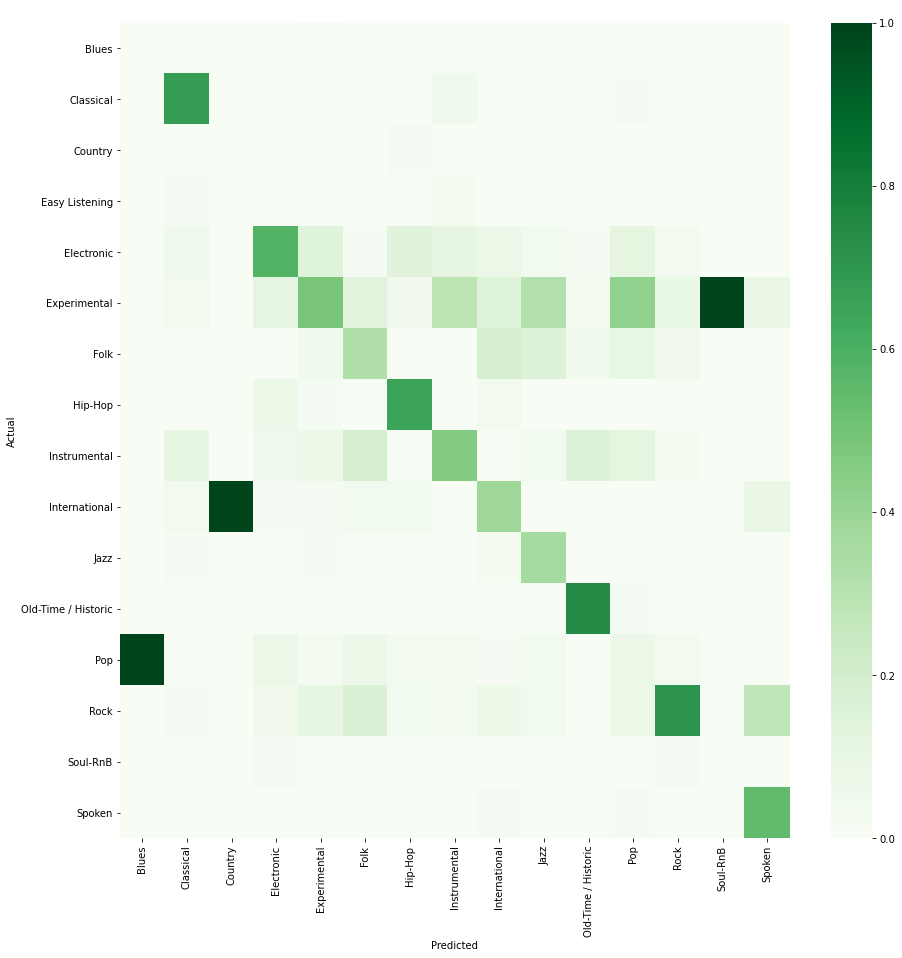

In [93]:
visualize_confusion_matrix(conf_matrix)

# Feature Importance

## Random Forest Classifier

In [10]:
from sklearn.ensemble import (
    RandomForestClassifier
)
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

<BarContainer object of 50 artists>

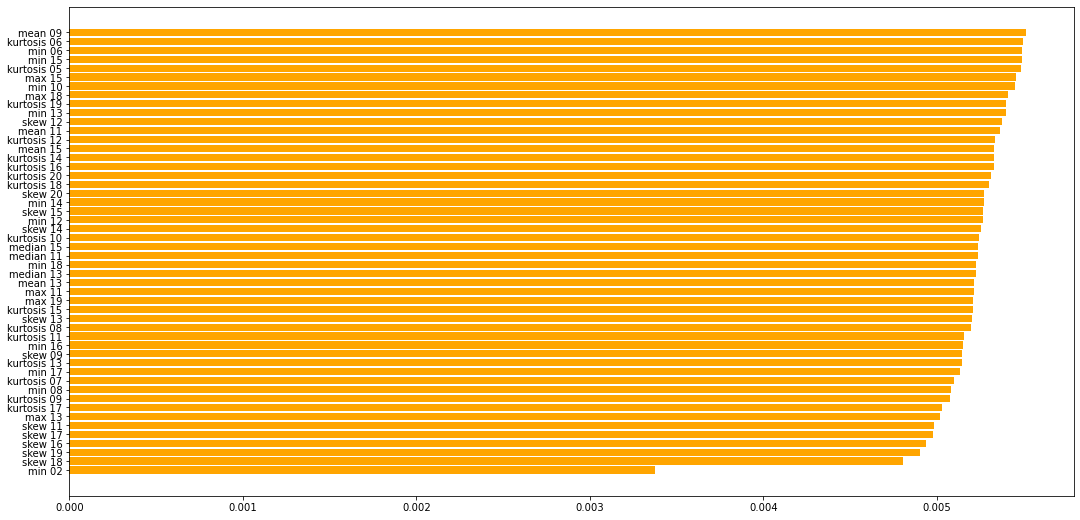

In [12]:
sorted_idx = importances.argsort()


plt.figure(figsize = (18, 9))
plt.barh(
    list(
    map(
        lambda x: ' '.join(x),
        feature_cols[sorted_idx][:50]
    )
), 
importances[sorted_idx][:50],
color = 'orange'
)

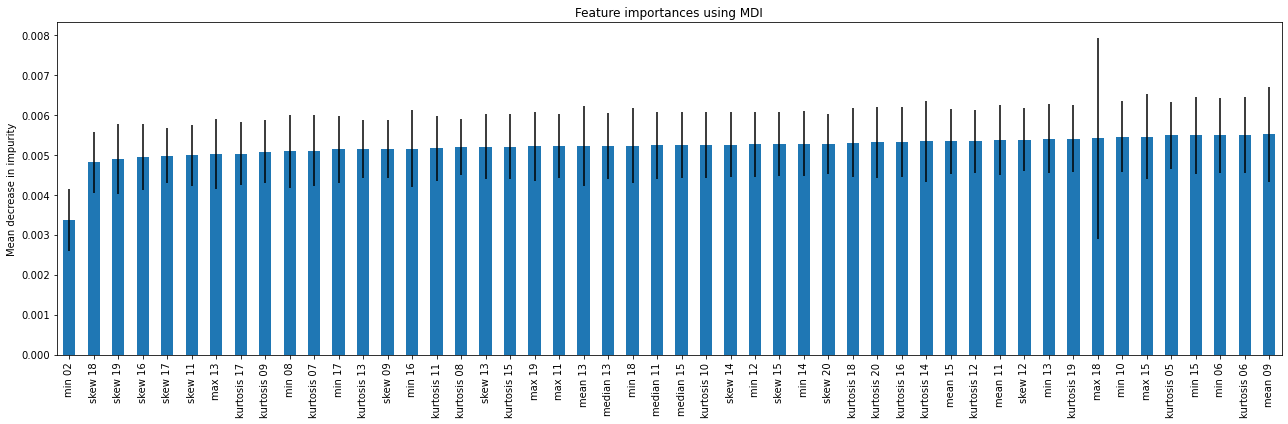

In [13]:
forest_importances = pd.Series(importances[sorted_idx][:50], index=list(
    map(
        lambda x: ' '.join(x),
        feature_cols[sorted_idx][:50]
    )
)
)



fig, ax = plt.subplots(figsize=(18, 6))
forest_importances.plot.bar(yerr=std[sorted_idx][:50], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()